# Comparative Analysis of Sentiment Analysis Techniques

In this project, we will draw comparisons between traditional statistical analysis tools and cutting-edge AI/ML models. This notebook will examine of the capabilities of SAS against a model built using a BERT transformer and an XGBoost model.

## Objective

The primary aim is to evaluate and contrast the effectiveness of each method in classifying sentiments expressed in a dataset composed of various tweets. This evaluation will focus on metrics such as accuracy, recall, and precision scores to evaluate each method's performance.

## Approach

1. Create "Gold Standard" testing dataset in TestData.ipynb.
2. Import in Data/MultiClassLabeledCustomTwitterSentiments.csv.
3. Perform Necessary pre-processing.
4. Train a Naive Bayes classifier as a baseline
5. Train an XGBoost Model On BERT Embeddings.
6. Test accuracy, precision, and recall on the "Gold Standard" dataset.
7. Analyze results. Explain why one model may work better than others and discuss interpretation of sarcasm and other figurative speech. 

If you are curious about the creation of the Gold Standard dataset, see the file "TestData.ipynb". I will start by importing the necessary libraries and defining necessary functions.

### Introduction to BERT and XGBoost

<b>BERT (Bidirectional Encoder Representations from Transformers)</b> is a natural language processing (NLP) model developed by Google. By pre-training on a large amount of text and then fine-tuning on specific tasks, BERT is able to capture a rich understanding of language semantics. Unlike traditional models that read text sequentially, BERT reads text bidirectionally, allowing it to grasp context from both directions. This capability makes it exceptionally powerful for tasks like sentiment analysis, question answering, and language translation.

<b>XGBoost (Extreme Gradient Boosting)</b> is an advanced implementation of gradient boosting algorithms. XGBoost was designed for speed and performance making it efficient at handling large-scale and complex data. It builds multiple models sequentially, with each new model correcting errors made by the previous ones. XGBoost is particularly versatile, being applicable to a wide range of regression, classification, and ranking problems across different domains.

Together, BERT's deep understanding of language nuances and XGBoost's powerful predictive capabilities make a formidable combination for tackling advanced NLP tasks, including sentiment analysis. In this project, we leverage BERT to generate embeddings that capture the contextual meanings of tweets, which are then fed into an XGBoost model to predict the sentiment expressed in each tweet.

Next, import the packages and set up global variables.

In [1]:
# Standard data science imports 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & EDA
import re
import emoji
import string
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

# XGBoost
import xgboost as xgb

#metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Global Vars
seed = 10

/Users/oga/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 2

Now I will now read in the "Gold Standard" data and display some basic information about it.

In [2]:
data = pd.read_csv('Data/MultiClassLabeledCustomTwitterSentiments.csv', encoding='utf-8',  dtype={'text': str})
# Display info
print(f"Num rows: {data.shape[0]}")
data.head()

Num rows: 453


,text,target
0,I don't know about you but I think Alden Ehren...,4
1,The PR for DLPack support in CuPy has been mer...,4
2,Oh ffs. Such bs. How did he react to recent Co...,0
3,Super cool reimplementation (+ new stuff) of ...,4
4,Now targeting June 1 launch of SES-12 from Pad...,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    453 non-null    object
 1   target  453 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.2+ KB


We have no null Values in the data. Now let's view the distribution of the classes.

In [4]:
# Only needed if there were null values in the set
data = data.dropna()

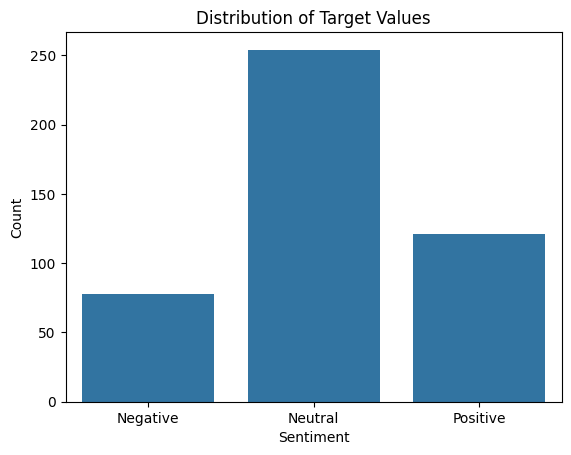

In [5]:
# Map the numerical target values to categories
data['target_label'] = data['target'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# Plotting the distribution 
sns.countplot(x='target_label', data=data, order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribution of Target Values')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

As you can see from the countplot distribution, the data is somewhat imbalanced with a minority of Negative tweets. There are almost double the amount of Neutral tweets as there are either Negative or Positive tweets. These imbalances can lead to biases when training the model, so I will perform a pre-processing technique called oversampling later in step 3 to help.

## Step 3

Now I will perform preprocessing of the data. Below, I have a list of functions that will be ran as a pipeline to preprocess all of the data. The first function is a function to convert all emojis to their english string equivalents. I do this since I read [here](https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e) that including rather than removing emojis can increase accuracy. Next, I strip all the characters that are not informative (punctuation, links, etc.). I then remove all hashtags from the text, and then remove all illegal characters. Lastly, I remove any back-to-back spaces. These preprocessing steps are all done to simplify the text as much as possible and remove any parts of the text that are not informative. 

In [6]:
# Function to replace emojis in text with their textual representations
#   Input: String representing a tweet text
#   Output: De-Emojied String
def convert_emoji(text):
    # Use the 'demojize' function from the emoji library
    return emoji.demojize(text, delimiters=("", ""))

#Remove punctuations, links, mentions
def strip_all_entities(text): 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def run_pipeline(text):
    texts_new = []
    
    for t in text:
        texts_new.append(remove_mult_spaces(
                filter_chars(
                    clean_hashtags(
                        strip_all_entities(
                            convert_emoji(t)
                        )
                    )
                )
        )
    )
    return texts_new
    

data["cleaned_text"] = run_pipeline(data.text)

Let's examine the cleaned data

In [7]:
data["cleaned_text"].head()

0    I dont know about you but I think Alden Ehrenr...
1    The PR for DLPack support in CuPy has been mer...
2    Oh ffs Such bs How did he react to recent Cons...
3    Super cool reimplementation new stuff of our d...
4    Now targeting June 1 launch of SES12 from Pad ...
Name: cleaned_text, dtype: object

Below is a visualization of how many words are in each tweet after cleaning the data. This is important to examine because after cleaning the text, there is possibility that some tweets could end up with a total length of 0. Also, the shorter the tweet the less information the tweet contains for the model to learn off of. 

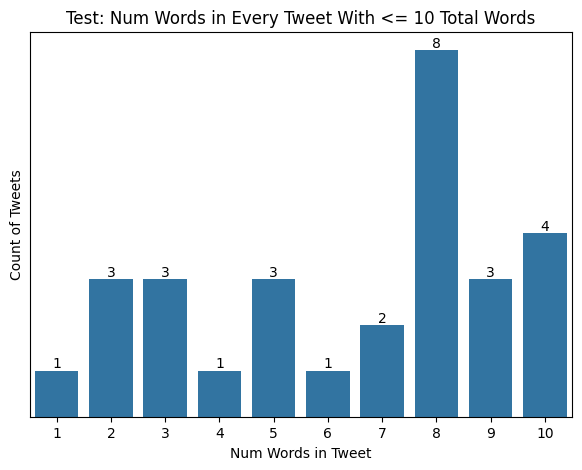

Total Rows: 29


In [8]:
text_len_threshhold = 10

text_len = []
for text in data.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

data['text_len'] = text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<=text_len_threshhold])
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count of Tweets')
plt.xlabel('Num Words in Tweet')
plt.title(f'Test: Num Words in Every Tweet With <= {text_len_threshhold} Total Words')
plt.show()

print(f'Total Rows: {data[data["text_len"]<=text_len_threshhold].shape[0]}')


As you can see, there are no empty tweets after cleaning, and there are 29 total entries with 10 or less words. I arrived at 10 words as a good threshhold through trial and error. We will go ahead and remove all these rows to increase accuracy.

In [9]:
print(f'Total rows before removing: {data.shape[0]}')
data = data[data["text_len"] > text_len_threshhold]
print(f'Total rows after removing: {data.shape[0]}')

Total rows before removing: 453
Total rows after removing: 424


Now lets re-examine the distribution of classes across the data.

In [10]:
data['target'].value_counts()

target
2    241
4    108
0     75
Name: count, dtype: int64

As we saw earlier, the classes are biased towards class 2 (positive). I will use oversampling to balance the data. Oversampling is a technique used in statistics and machine learning to balance uneven datasets. It involves artificially creating copies of instances of the minority class or generating new instances that are similar to the existing ones. This helps prevent the model from being biased towards the majority class, improving its ability to learn and predict the minority class effectively. However, oversampling can also lead to overfitting. I take great care to prevent overfitting for this model since there is so little data, so I am not too worried about using the oversampler. 

In [11]:
ros = RandomOverSampler(random_state=seed)
train_x, train_y = ros.fit_resample(np.array(data['cleaned_text']).reshape(-1, 1), np.array(data['target']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['cleaned_text', 'sentiment'])
train_os['sentiment'].value_counts()

sentiment
4    241
0    241
2    241
Name: count, dtype: int64

## Step 4

Now I will train a Naive Bayes Classifier as a baseline model to compare against. The Naive Bayes is built by first tokenizing the data using CountVectorizer, then taking the tokenized data and turning them into TF-IDF scores, and then fitting on those scores.

In [12]:
X = train_os['cleaned_text'].values
y = train_os['sentiment'].values

# First split: 70% train, 30% temporary (to be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

# Second split: Split the 30% temporary data into 15% validation and 15% test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)


y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

encoder = preprocessing.OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1))
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))

clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_valid_cv = clf.transform(X_valid)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_valid_tf = tf_transformer.transform(X_valid_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)


MultinomialNB()

Now let's examine the results:

In [13]:

nb_pred = nb_clf.predict(X_test_tf)
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['negative', 'neutral', 'positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    negative       0.77      1.00      0.87        36
     neutral       1.00      0.41      0.58        37
    positive       0.72      0.94      0.82        36

    accuracy                           0.78       109
   macro avg       0.83      0.78      0.75       109
weighted avg       0.83      0.78      0.75       109



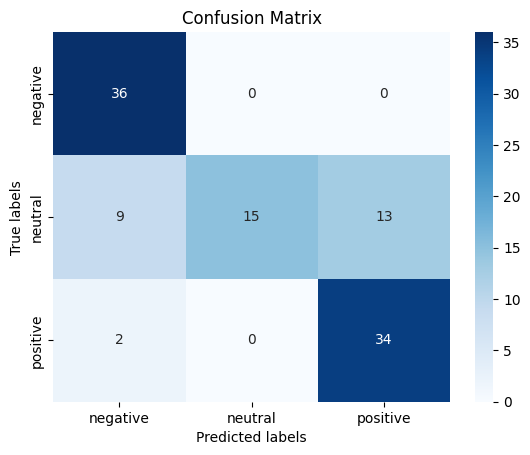

In [14]:
cm = confusion_matrix(y_test_le, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The classification report tells us that we are getting a 75% accuracy on a Multinomial Naive Bayes classifier after our datacleaning and preprocessing. The recall score is especially low for the neutral class. After looking at the confusion matrix, we can say that this low recall score is due to the model misclassifying true neutral labels as either positive or negative. The model does extremely well at predicting the positive and negative labels. 

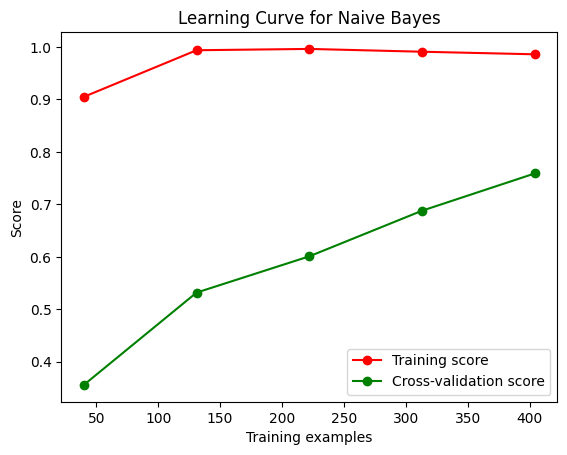

In [15]:


train_sizes, train_scores, test_scores = learning_curve(MultinomialNB(), X_train_tf, y_train_le, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve for Naive Bayes")
plt.legend(loc="best")
plt.show()


You can also see from the learning curve displayed above that the training score is consistently high across the number of training examples. This indicates that the classifier is performing well on the training set. You can also see that the model is not overfitting, since the cross validation score is still increasing after all training examples. The fact that the CV score is still increasing means that there was probably not enough data and that this model would perform even better with more data. There is also a noticeable gap between the training and cross-validation scores, but this gap is not widening as more training examples are added. Instead, the cross-validation score seems to be catching up with the training score, which implies the model is generalizing better as it sees more data.

## Step 5

Now I will build and train the BERT model.

The first step is to tokenize the cleaned and oversampled tweets. Tokenizing involves breaking down text into smaller pieces, known as tokens. Tokenization is important becauseit helps BERT deal with unfamiliar words more effectively, thus reducing the problem of out-of-vocabulary words significantly. It also keeps the model smaller, more efficient, and more accuracte. Below, I will tokenize all the tweets and display a distribution of the lengths of the tokenized tweets.

MAX TOKENIZED SENTENCE LENGTH: 54


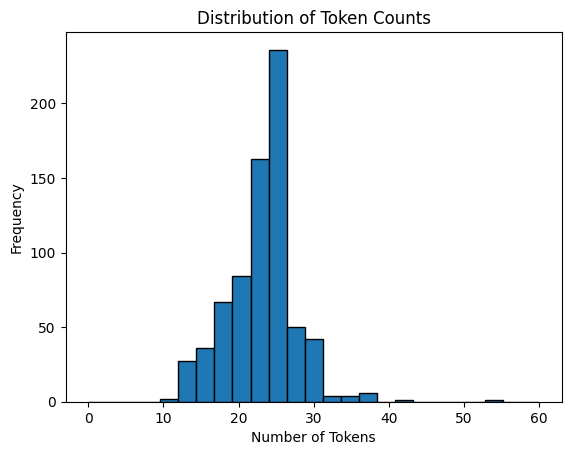

Average token count: 22.986168741355463


In [16]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def token_distribution(texts):
    # Tokenize each text and count the tokens
    token_counts = [len(tokenizer.tokenize(text)) for text in texts]

    print(f"MAX TOKENIZED SENTENCE LENGTH: {np.max(token_counts)}")
    
    # Plot the distribution of token counts up to 60
    plt.hist(token_counts, bins=25, range=(0,60), edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Counts')
    plt.show()
    
    # Calculate the average token count excluding the counts over 60
    average_token_count = sum(token_counts) / len(token_counts) if token_counts else 0
    print(f"Average token count: {average_token_count}")
    
    # Return the average token count for texts with 60 tokens or less
    return average_token_count

average_length_in_tokens = token_distribution(train_os['cleaned_text'].tolist())

The distribution above has a couple of key points. First, there is a peak around 25 tokens, and we can see that this data has a central tendency meaning thaey are clustered in a small range towards the center. There are only a couple of outliers, and they are insignificant enough to ignore, especially since we will be padding and truncating the results. Padding involves adding extra tokens to shorter sequences to make them the same length as the specified maximum length. Truncating involves cutting off elements from sequences that are longer than the desired fixed length. Based on the distribution, the optimal number of tokens for padding and truncating should be around 35. This number  captures the majority of the data without losing too much information.

Next I will extract the embeddings using padding and truncation from the previously used train, test, and validation data. 

In [17]:
MAX_LEN=35
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def extract_embeddings(data, model, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    
    # Getting embeddings from the BERT model
    embeddings = model.predict([input_ids, attention_masks])[1]  # Use pooler output (index 1)
    return embeddings

# Extract embeddings
train_embeddings = extract_embeddings(X_train, bert_model, MAX_LEN)
val_embeddings = extract_embeddings(X_valid, bert_model, MAX_LEN)
test_embeddings = extract_embeddings(X_test, bert_model, MAX_LEN)


2024-04-28 17:51:34.286734: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-28 17:51:34.286756: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-28 17:51:34.286764: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-28 17:51:34.286778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 17:51:34.286787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.tran

4/4 [==============================] - 3s 763ms/step


Now that the BERT model has been used to create the embeddings, we can feed those embeddings to the XGBoost model to get output class labels. My XGBoost is set up with a max_depth of 6, as this is fairly standard. The Learning rate starts at 0.2, but I implement a Learning rate decay to attempt to a) prevent overfitting, and b) increase accuracy on such a small dataset. This helps combine the benefits of a high learning rate (faster convergence and higher potential to escape poor local minima) with the benefits of a lower learning rate (better generalization and less sensitivity). I also implement early stopping in my model to prevent overfitting. This is extremely important since my model is trained on such a small dataset. After training the model, I display the training vs validation log loss to inspect performance and overfitting.

[0]	train-mlogloss:0.88411	validation-mlogloss:0.95797
[1]	train-mlogloss:0.72744	validation-mlogloss:0.84129
[2]	train-mlogloss:0.61214	validation-mlogloss:0.75680
[3]	train-mlogloss:0.52550	validation-mlogloss:0.70107
[4]	train-mlogloss:0.45720	validation-mlogloss:0.64445
[5]	train-mlogloss:0.40443	validation-mlogloss:0.60581
[6]	train-mlogloss:0.36130	validation-mlogloss:0.57435
[7]	train-mlogloss:0.32756	validation-mlogloss:0.55333
[8]	train-mlogloss:0.29863	validation-mlogloss:0.53607
[9]	train-mlogloss:0.27501	validation-mlogloss:0.51575
[10]	train-mlogloss:0.25447	validation-mlogloss:0.50440
[11]	train-mlogloss:0.23528	validation-mlogloss:0.49165
[12]	train-mlogloss:0.21947	validation-mlogloss:0.47809
[13]	train-mlogloss:0.20541	validation-mlogloss:0.47042
[14]	train-mlogloss:0.19310	validation-mlogloss:0.46259
[15]	train-mlogloss:0.18241	validation-mlogloss:0.45535
[16]	train-mlogloss:0.17199	validation-mlogloss:0.44665
[17]	train-mlogloss:0.16288	validation-mlogloss:0.43935
[1

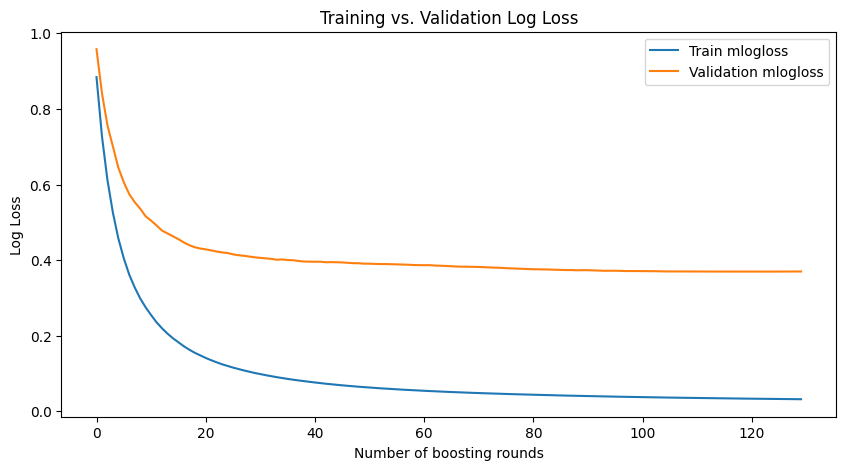

In [18]:
# Prepare labels (ensure y_train, y_valid are in the correct format for XGBoost)
train_labels = np.argmax(y_train.toarray(), axis=1)
val_labels = np.argmax(y_valid.toarray(), axis=1)

# Train XGBoost model
dtrain = xgb.DMatrix(train_embeddings, label=train_labels)
dvalid = xgb.DMatrix(val_embeddings, label=val_labels)
dtest = xgb.DMatrix(test_embeddings)

params = {
    'max_depth': 6,
    'eta': 0.2,
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed': seed
}

early_stopping = 10

class LearningRateDecayCallback(xgb.callback.TrainingCallback):
    def __init__(self, initial_rate=0.2, decay_rate=0.1):
        self.initial_rate = initial_rate
        self.decay_rate = decay_rate

    def after_iteration(self, model, epoch, evals_log):
        # Calculate the new learning rate
        new_rate = self.initial_rate / (1 + self.decay_rate * epoch)
        # Set the new learning rate
        model.set_param('learning_rate', new_rate)
        return False  # Return False to continue training
    
# Initialize the callback
learning_rate_decay = LearningRateDecayCallback(initial_rate=0.2, decay_rate=0.1)

# Use the callback with XGBoost
callbacks = [learning_rate_decay]
# Train model with early stopping, Learning Rate Schedules, and evals
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtrain, 'train'), (dvalid, 'validation')],
                early_stopping_rounds=early_stopping, callbacks=callbacks, evals_result=evals_result)

# Access evaluation results
train_mlogloss = evals_result['train']['mlogloss']
val_mlogloss = evals_result['validation']['mlogloss']

# Plotting the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_mlogloss, label='Train mlogloss')
plt.plot(val_mlogloss, label='Validation mlogloss')
plt.xlabel('Number of boosting rounds')
plt.ylabel('Log Loss')
plt.title('Training vs. Validation Log Loss')
plt.legend()
plt.show()

The graph shows the log loss for a training set and a validation set across a number of boosting rounds in an XGBoost model. Log loss is a performance metric that assesses the accuracy of a classifier by penalizing false classifications. Lower log loss values indicate better performance.

Looking at the graph, the training log loss starts high and quickly decreases, showing that the model is learning from the training data. The validation log loss also decreases rapidly at the start, which means that the model initially generalizes well to unseen data. There is also no significant gap between the training and validation log loss, which is a good sign that overfitting is minimal. The validation log loss does not increase as the number of rounds grows, which would have been a clear indicator of overfitting.

Next I will re-evaluate the Log Loss on a cross validation KFolds with 5 folds. This is just to guarantee that the loss values seen previously are accurate and not a fluke. I had to implement this custom to use the learning rate scheduling. 

In [19]:
from sklearn.model_selection import KFold

# Prepare the full dataset DMatrix
data_matrix = xgb.DMatrix(np.concatenate([train_embeddings, val_embeddings]),
                          label=np.concatenate([train_labels, val_labels]))

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store fold results
fold_results = []

# Manual KFold Cross-Validation with learning rate schedule
for train_index, test_index in kf.split(np.concatenate([train_embeddings, val_embeddings])):
    X_train, X_test = data_matrix.slice(train_index), data_matrix.slice(test_index)
    callbacks = [LearningRateDecayCallback(initial_rate=0.1, decay_rate=0.01)]
    evals_result = {}
    model = xgb.train(params, X_train, num_boost_round=200,
                      evals=[(X_train, 'train'), (X_test, 'test')],
                      early_stopping_rounds=early_stopping, callbacks=callbacks,
                      evals_result=evals_result)
    fold_results.append(model.best_score)

# Calculate the average performance across all folds
average_performance = np.mean(fold_results)
print(f"Average performance across all folds: {average_performance}")

[0]	train-mlogloss:0.88271	test-mlogloss:0.96147
[1]	train-mlogloss:0.80202	test-mlogloss:0.91177
[2]	train-mlogloss:0.73016	test-mlogloss:0.86266
[3]	train-mlogloss:0.66410	test-mlogloss:0.82321
[4]	train-mlogloss:0.60734	test-mlogloss:0.78742
[5]	train-mlogloss:0.55895	test-mlogloss:0.75882
[6]	train-mlogloss:0.51374	test-mlogloss:0.73011
[7]	train-mlogloss:0.47381	test-mlogloss:0.70561
[8]	train-mlogloss:0.43880	test-mlogloss:0.68843
[9]	train-mlogloss:0.40644	test-mlogloss:0.67008
[10]	train-mlogloss:0.37680	test-mlogloss:0.64912
[11]	train-mlogloss:0.35170	test-mlogloss:0.63201
[12]	train-mlogloss:0.32745	test-mlogloss:0.61719
[13]	train-mlogloss:0.30511	test-mlogloss:0.60314
[14]	train-mlogloss:0.28565	test-mlogloss:0.59196
[15]	train-mlogloss:0.26645	test-mlogloss:0.58033
[16]	train-mlogloss:0.25016	test-mlogloss:0.57106
[17]	train-mlogloss:0.23427	test-mlogloss:0.56568
[18]	train-mlogloss:0.22011	test-mlogloss:0.55680
[19]	train-mlogloss:0.20697	test-mlogloss:0.54816
[20]	train

Since the average performance across all folds is relatively similar to the value we analyszed on the graph (0.36 vs 0.38), we can say that those results were not by chance or an accident.

## Step 6

Next I will predict the labels of the test data and analyze the results using a confusion matrix and precision, accuracy, and recall scores. 

In [20]:
# Prediction
preds = bst.predict(dtest)

# Assuming 'y_test' are your true labels and need to be in the correct numerical format
test_labels = np.argmax(y_test.toarray(), axis=1)  # Convert from one-hot if necessary

# Classification Report
print('\tClassification Report for BERT:\n\n',classification_report(test_labels, preds, target_names=['Negative', 'Neutral', 'Positive']))


	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.90      1.00      0.95        36
     Neutral       0.97      0.81      0.88        37
    Positive       0.89      0.94      0.92        36

    accuracy                           0.92       109
   macro avg       0.92      0.92      0.92       109
weighted avg       0.92      0.92      0.92       109



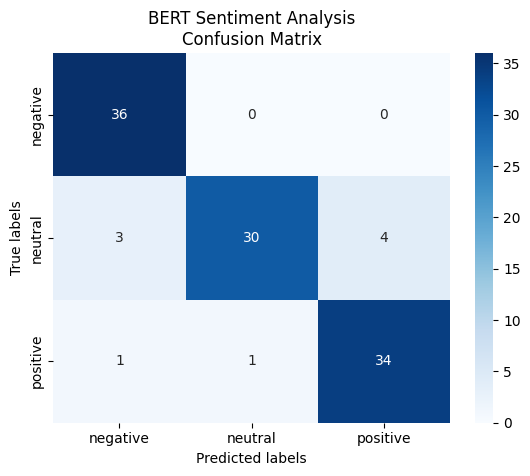

In [21]:

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('BERT Sentiment Analysis\nConfusion Matrix')
plt.show()


## Step 7
### EDA:

The XGBoost+BERT model is performing with a 92% accuracy, which is much better than the 78% we got from the Naive Bayes. We can see that the majority of the misclassifications were the result of True neutral labels being misclassified as positive or negative, which is supported by the fact that the neutral recall is the lowest. This is the exact same as the Naive Bayes, which leads me to believe that this inconsistency is an issue related to the data, where perhaps I labelled too many tweets as neutral that should not have been. Another possibility is that  Neutral sentiments might be more ambiguous or harder to distinguish from other sentiments. This can happen if the linguistic cues for neutrality are subtle or overlap significantly with those used to express negative or positive sentiments.

Next I will pull up a couple of examples and use them to examine the interpretation of sarcasm. The first example will be an example from the dataset that was used for training/testing/validation, and the second will be an example from the database that was not a part of the previous data

In [22]:
text = train_os.iloc[573].cleaned_text
print(text)

Muslim woman in Hijab makes valid points and audience members tell her to calm down Funny that Muslim woman who doesnt


This example is from the training datset, and is a blatantly sarcastic comment.

In [23]:
def predict_sentiment(text, tokenizer, bert_model, xgb_model):
    # Step 1: Tokenize the text
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    input_ids = np.array([encoded['input_ids']])
    attention_masks = np.array([encoded['attention_mask']])

    # Step 2: Extract embeddings using the BERT model
    embeddings = bert_model.predict([input_ids, attention_masks])[1]  # Use pooler output (index 1)
    
    # Step 3: Create a DMatrix for XGBoost
    dmatrix = xgb.DMatrix(embeddings)
    
    # Step 4: Predict with XGBoost
    prediction = xgb_model.predict(dmatrix)
    
    # Optionally, convert numerical prediction back to a label
    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_label = label_map[int(prediction[0])]
    
    return predicted_label

predicted_sentiment = predict_sentiment(text, tokenizer, bert_model, bst)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 2s 2s/step
Predicted Sentiment: Negative


As you can see, the Model accurately predicts this as negative sentiment; however, This does not mean much as the datapoint has already been seen by the model.

In [24]:
text = "Please trash me on Wikipedia, I’m begging you"
predicted_sentiment = predict_sentiment(text, tokenizer, bert_model, bst)
print("Predicted Sentiment:", predicted_sentiment)

text = "Just spilled my coffee all over my white shirt. Great start to the day! Can't wait to see what other surprises are in store for me. "
predicted_sentiment = predict_sentiment(text, tokenizer, bert_model, bst)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 334ms/step
Predicted Sentiment: Negative
1/1 [==============================] - 0s 194ms/step
Predicted Sentiment: Negative


Next I try to predict the sentiment of another sarcastic twitter status from the database, as well as a sarcastic tweet I found on google. Both of these tweets correctly classify as negative, which was slightly surprising because of the amount of positive words especially in the second text. This means two things: First, my model actually does do a pretty good job at detecting sarcasm. Even though this was a very small set of examples, it still shows a very strong capability of recognizing sarcasm. Secondly, the fact that it can correctly classify a tweet that was not a part of the classes original PostgreSQL database means that this data should be generalizable to bigger set of tweets, and may even be generalizable to things other than tweets, assuming that text length stays relatively similar. 

### Discussion on Improvements

The biggest improvement to be made on this model is increasing the dataset size. The model does not overfit, generalizes well, and maintains a high accuracy on this small of a dataset; however, it would be even more robust and generalizable with a bigger dataset (at least 100+ entries), which is clear from the Log Loss graph. It coukd also be improved further by performing further training on the BERT model. Right now, the BERT embeddings are generated using an out-of-the-box pretrained model, but if we were to train it further on tweets specifically from this PostgreSQL database, it might be able to further understand the nuances of syntax and semantics that are exclusive to twitter. It is worth noting, however, that further training the BERT model specifically on tweets could take away from the ability to generalize to things other than tweets, as I discussed earlier.